In [1]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from transformers import GPT2Model, GPT2Config, AdamW

# 시드 설정 (재현성을 위해)
torch.manual_seed(42)
np.random.seed(42)

In [3]:
df = pd.read_csv('/content/drive/MyDrive/bs.csv', encoding='cp949', index_col=0)
df

,수입(TEU),수출(TEU),수입환적(TEU),수출환적(TEU),수입물가지수,usd비율(Yuan/US),Dubai국제유가(US/배럴),강수량(mm),평균기온,평균최저기온,평균최고기온
Date,,,,,,,,,,,
2014-01,353916.0,365515.0,408239.0,389980.0,128.15,6.105,104.0,9.6,5.0,1.2,9.7
2014-02,334478.0,334191.0,313752.0,350400.0,128.34,6.121,105.0,44.1,5.8,2.7,9.9
2014-03,405896.0,402861.0,410436.0,383564.0,127.66,6.152,104.4,136.7,9.8,6.2,14.5
2014-04,391682.0,402607.0,390004.0,401684.0,127.56,6.158,104.6,147.8,14.6,11.2,19.3
2014-05,396794.0,395189.0,402279.0,388978.0,127.70,6.169,105.6,145.9,18.7,15.4,23.2
...,...,...,...,...,...,...,...,...,...,...,...
2023-03,493589.0,465645.0,550140.0,540680.0,121.61,6.869,78.5,76.2,12.3,8.5,17.0
2023-04,462679.0,467042.0,535107.0,552678.0,120.72,6.923,83.4,101.6,14.6,11.0,19.0
2023-05,470224.0,470912.0,513907.0,515848.0,116.48,7.109,75.0,290.7,17.9,14.9,21.6


In [4]:
df = df.dropna()

In [5]:
X = df.iloc[:, 1:].values
Y = df.iloc[:, :1].values

In [6]:
# 표준화

scaler = MinMaxScaler()
x = scaler.fit_transform(X)
y = scaler.fit_transform(Y)

In [7]:
# Transformer 모델 설정
config = GPT2Config(hidden_size=12,
                    num_layers=4,
                    num_heads=4,
                    num_positions=12)

model = GPT2Model(config).cuda()

In [8]:
# gpu 모델로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

GPT2Model(
  (wte): Embedding(50257, 12)
  (wpe): Embedding(1024, 12)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
)

In [9]:
# pytorch tensor로 변환

x = torch.tensor(x, device=device)
y = torch.tensor(y, device=device)

In [10]:
x = torch.as_tensor(x, dtype=torch.float32, device='cuda')
y = torch.as_tensor(y, dtype=torch.float32, device='cuda')

In [11]:
# train, test set 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# DataLoader 생성
batch_size = 4
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# optimizer
optimizer = AdamW(model.parameters(), lr=1e-3)

# loss function
loss_fn = nn.MSELoss()

# 모델 학습
epochs = 150

trains = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(torch.as_tensor(inputs, dtype=torch.long, device=device))
        optimizer.zero_grad()
        loss = loss_fn(outputs.last_hidden_state[:, -1, 0], targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        trains.extend(outputs.last_hidden_state[:, -1, 0].cpu().detach().numpy())

    average_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch + 1} / {epochs} - Train Loss: {average_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 / 150 - Train Loss: 0.3188
Epoch 2 / 150 - Train Loss: 0.0505
Epoch 3 / 150 - Train Loss: 0.0375
Epoch 4 / 150 - Train Loss: 0.0450
Epoch 5 / 150 - Train Loss: 0.0404
Epoch 6 / 150 - Train Loss: 0.0409
Epoch 7 / 150 - Train Loss: 0.0414
Epoch 8 / 150 - Train Loss: 0.0440
Epoch 9 / 150 - Train Loss: 0.0441
Epoch 10 / 150 - Train Loss: 0.0464
Epoch 11 / 150 - Train Loss: 0.0423
Epoch 12 / 150 - Train Loss: 0.0423
Epoch 13 / 150 - Train Loss: 0.0413
Epoch 14 / 150 - Train Loss: 0.0396
Epoch 15 / 150 - Train Loss: 0.0453
Epoch 16 / 150 - Train Loss: 0.0408
Epoch 17 / 150 - Train Loss: 0.0422
Epoch 18 / 150 - Train Loss: 0.0426
Epoch 19 / 150 - Train Loss: 0.0446
Epoch 20 / 150 - Train Loss: 0.0417
Epoch 21 / 150 - Train Loss: 0.0409
Epoch 22 / 150 - Train Loss: 0.0429
Epoch 23 / 150 - Train Loss: 0.0435
Epoch 24 / 150 - Train Loss: 0.0431
Epoch 25 / 150 - Train Loss: 0.0426
Epoch 26 / 150 - Train Loss: 0.0418
Epoch 27 / 150 - Train Loss: 0.0428
Epoch 28 / 150 - Train Loss: 0.0390
E

In [13]:
# 모델 평가 (train set)
model.eval()
train_loss = 0
trains = []

with torch.no_grad():
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(torch.as_tensor(inputs, dtype=torch.long, device=device))
        loss = loss_fn(outputs.last_hidden_state[:, -1, 0], targets)
        train_loss += loss.item()

        trains.extend(outputs.last_hidden_state[:, -1, 0].cpu().numpy())

average_train_loss = train_loss / len(train_loader)
print(f'Validation Loss: {average_train_loss:.4f}')

Validation Loss: 0.0344


In [24]:
trains = np.array(trains).reshape(79, 1)

In [25]:
trained = scaler.inverse_transform(np.hstack((x_train.cpu().numpy(), trains)))[:, -1]
train_actual = scaler.inverse_transform(np.concatenate((x_train.cpu().numpy(), y_train.cpu().numpy().reshape(-1,1)), axis=1))[:, -1]

In [14]:
batch_size=2
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# 모델 평가
model.eval()
test_loss = 0
predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(torch.as_tensor(inputs, dtype=torch.long, device=device))
        loss = loss_fn(outputs.last_hidden_state[:, -1, 0], targets)
        test_loss += loss.item()

        predictions.extend(outputs.last_hidden_state[:, -1, 0].cpu().numpy())

average_test_loss = test_loss / len(test_loader)
print(f'Validation Loss: {average_test_loss:.4f}')

Validation Loss: 0.0329


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [16]:
predictions = np.array(predictions).reshape(34, 1)

In [17]:
predicted = scaler.inverse_transform(np.hstack((x_test.cpu().numpy(), predictions)))[:, -1]
actual = scaler.inverse_transform(np.concatenate((x_test.cpu().numpy(), y_test.cpu().numpy().reshape(-1,1)), axis=1))[:, -1]

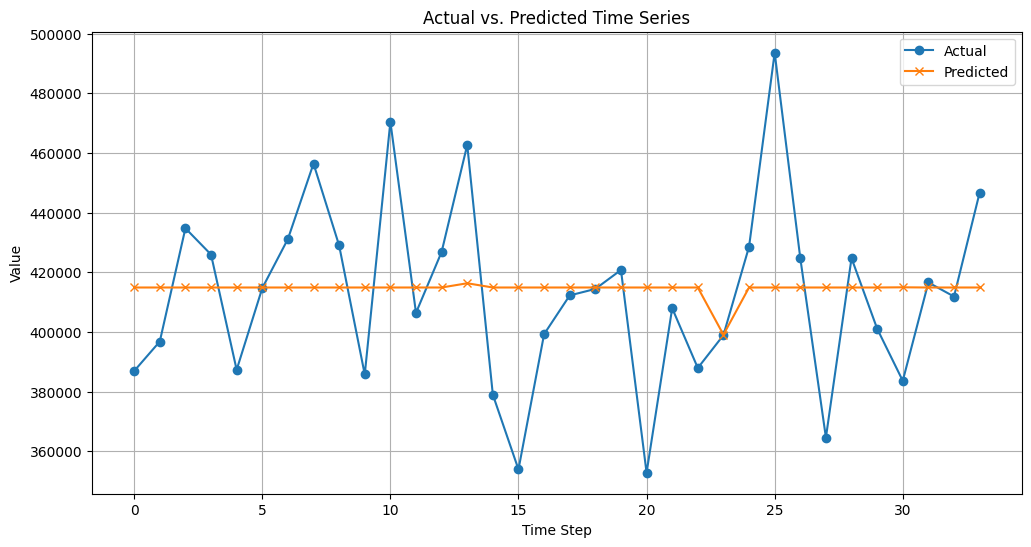

In [18]:
import matplotlib.pyplot as plt

# 예측 결과와 실제 데이터 그래프로 그리기
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual', marker='o')
plt.plot(predicted, label='Predicted', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Time Series')
plt.legend()
plt.grid(True)
plt.show()

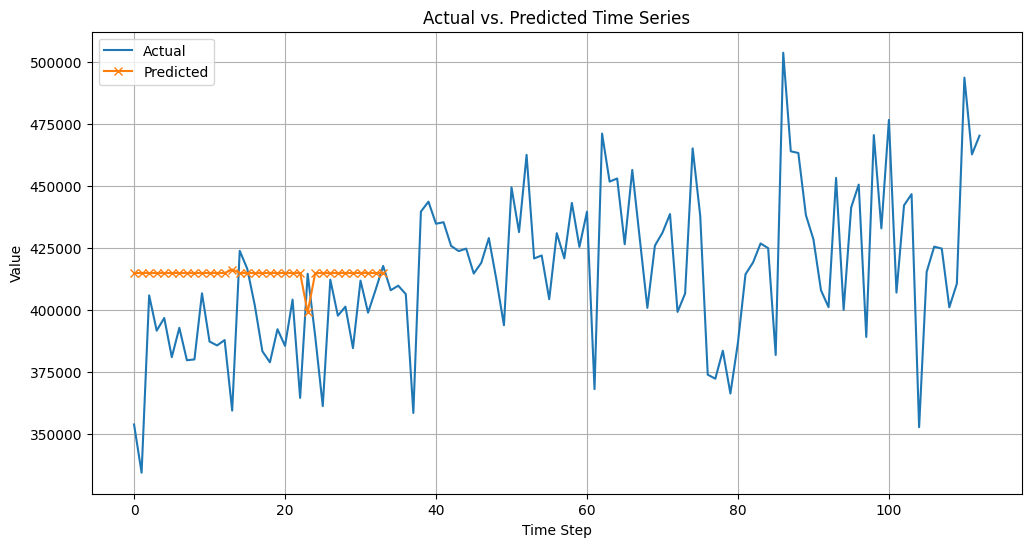

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(Y, label='Actual')
plt.plot(scaler.inverse_transform(predictions), label='Predicted', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Time Series')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
import copy
data_combined_x = np.concatenate((x_train.cpu(), x_test.cpu()), axis=0)
data_combined_y = np.concatenate((y_train.cpu(), y_test.cpu()), axis=0)
PlotEstimated = np.empty_like(np.concatenate((data_combined_x, data_combined_y), axis=1))
PlotEstimated[:, :] = np.nan

In [33]:
trained = trained.reshape(79,1)

In [36]:
predicted = predicted.reshape(34, 1)

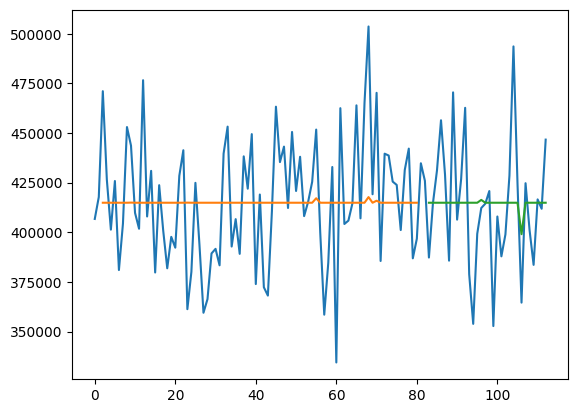

In [41]:
#PlotEstimated의 복사본
trainPlotEstimated = copy.deepcopy(PlotEstimated)
trainPlotEstimated[2:len(trained)+2, -1:] = trained
testPlotEstimated = copy.deepcopy(PlotEstimated)
testPlotEstimated[len(trained)+2+2:114, -1:] = predicted[:-4, :]

#실제 데이터, 학습데이터, 테스트 데이터의 예측값 그래프로
plt.plot(scaler.inverse_transform(data_combined_y))
plt.plot(trainPlotEstimated)
plt.plot(testPlotEstimated)
plt.show()